First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib import image
import os
import sys
import tarfile
import imagehash
from PIL import Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
# 下载 notMNIST_large.tar.gz 和 notMNIST_small.tar.gz 数据集
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '../../nlp_data_set/notmnist/' # Change me to store data elsewhere

In [ ]:
def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
    if percent % 5 == 0:
        sys.stdout.write("%s%%" % percent)
        sys.stdout.flush()
    else:
        sys.stdout.write(".")
        sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, 
                                  reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
          'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
os.path.splitext(os.path.splitext('notMNIST_large.tar.gz')[0])[0]

'notMNIST_large'

In [4]:
# 解压下载的数据包
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    filename = data_root + filename
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
          'Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_filename = 'notMNIST_large.tar.gz'
test_filename = 'notMNIST_small.tar.gz'
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

../../nlp_data_set/notmnist/notMNIST_large already present - Skipping extraction of ../../nlp_data_set/notmnist/notMNIST_large.tar.gz.
['../../nlp_data_set/notmnist/notMNIST_large/A', '../../nlp_data_set/notmnist/notMNIST_large/B', '../../nlp_data_set/notmnist/notMNIST_large/C', '../../nlp_data_set/notmnist/notMNIST_large/D', '../../nlp_data_set/notmnist/notMNIST_large/E', '../../nlp_data_set/notmnist/notMNIST_large/F', '../../nlp_data_set/notmnist/notMNIST_large/G', '../../nlp_data_set/notmnist/notMNIST_large/H', '../../nlp_data_set/notmnist/notMNIST_large/I', '../../nlp_data_set/notmnist/notMNIST_large/J']
../../nlp_data_set/notmnist/notMNIST_small already present - Skipping extraction of ../../nlp_data_set/notmnist/notMNIST_small.tar.gz.
['../../nlp_data_set/notmnist/notMNIST_small/A', '../../nlp_data_set/notmnist/notMNIST_small/B', '../../nlp_data_set/notmnist/notMNIST_small/C', '../../nlp_data_set/notmnist/notMNIST_small/D', '../../nlp_data_set/notmnist/notMNIST_small/E', '../../n

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

    在加载数据时，由于电脑内存的限制，无法一次性加载所有的数据，因此我们需要把每一种class的数据单独加载并保存在磁盘中，最后再一起合并到一个数据集中。
    我们将把整个数据集转换成一个由浮点值组成的3d数组（index，x，y），标准化为平均值约为零，标准差约为0.5，这样训练就更容易了。
    其中，一些图像可能不可读，我们将跳过它们。

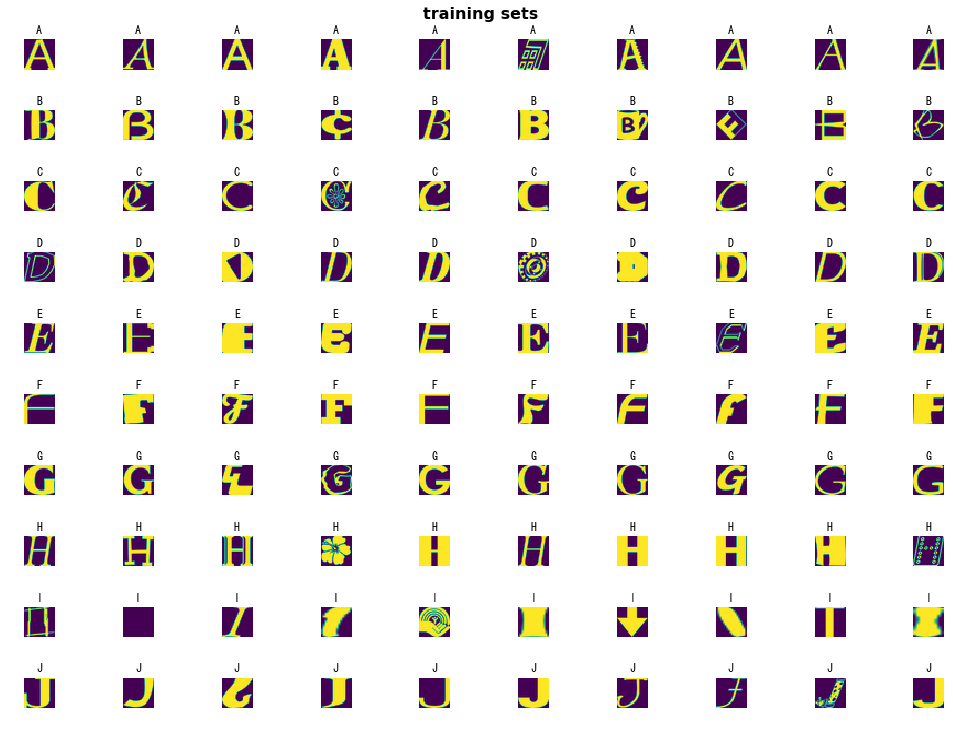

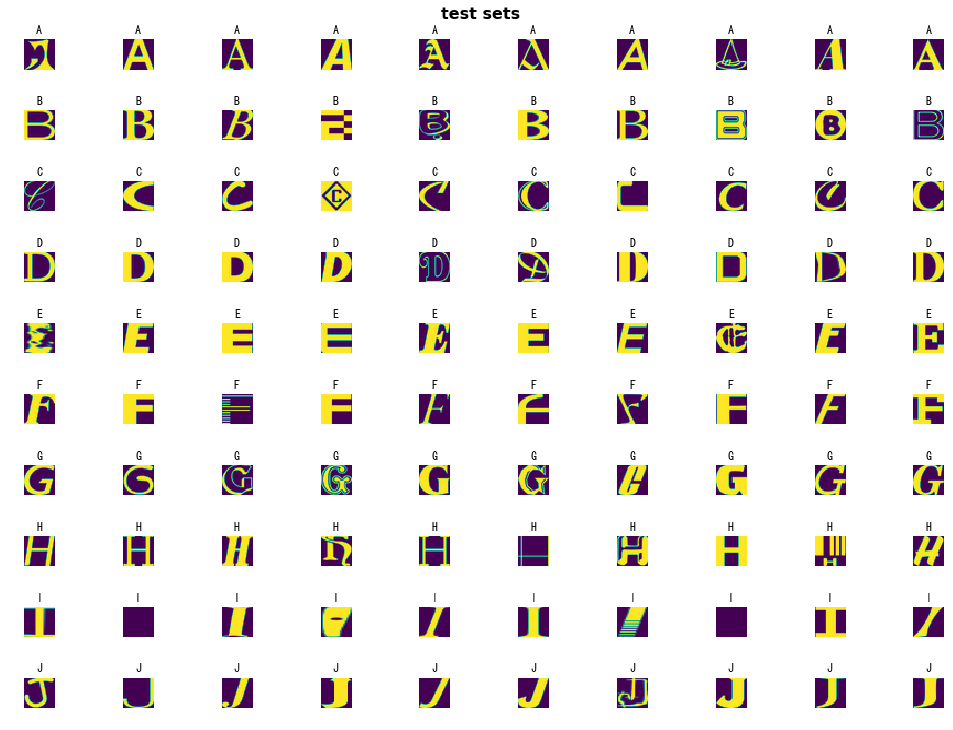

In [5]:
# 查看原始图片
def plot_samples(path, sample_size, title=None):
    fig, axes = plt.subplots(10, sample_size, figsize=(14, 10))
    if title: fig.suptitle(title, y=1.01, fontsize=16, fontweight='bold')
    path = os.path.join(data_root, path)
    i = 0
    for d in sorted(os.listdir(path)):
        if d.endswith('.pickle'): continue
        if d.endswith('.DS_Store'): continue
        image_path = os.path.join(path, d)
        image_files = random.sample(os.listdir(image_path), sample_size)
        for j, im in enumerate(image_files):
            im = image.imread(os.path.join(image_path, im))
            axes[i, j].imshow(im)
            axes[i, j].set_title(d)
            axes[i, j].set_axis_off()
        i += 1
    fig.tight_layout()
plot_samples('notMNIST_large', 10, 'training sets')
plot_samples('notMNIST_small', 10, 'test sets')

In [6]:
# 数据预处理, 不同的 class 保存到对应的 .pickle 文件中。
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - 
                        pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            pass
            # print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images, 
                                                                     min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

../../nlp_data_set/notmnist/notMNIST_large/A.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/B.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/C.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/D.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/E.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/F.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/G.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/H.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/I.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_large/J.pickle already present - Skipping pickling.
../../nlp_data_set/notmnist/notMNIST_small/A.pickle already present - Skipping pickling.
../../nlp_data_set/no

In [7]:
train_datasets

['../../nlp_data_set/notmnist/notMNIST_large/A.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/B.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/C.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/D.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/E.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/F.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/G.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/H.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/I.pickle',
 '../../nlp_data_set/notmnist/notMNIST_large/J.pickle']

In [8]:
test_datasets

['../../nlp_data_set/notmnist/notMNIST_small/A.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/B.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/C.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/D.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/E.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/F.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/G.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/H.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/I.pickle',
 '../../nlp_data_set/notmnist/notMNIST_small/J.pickle']

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

    验证一下选择出来的好的数据，并画图
---

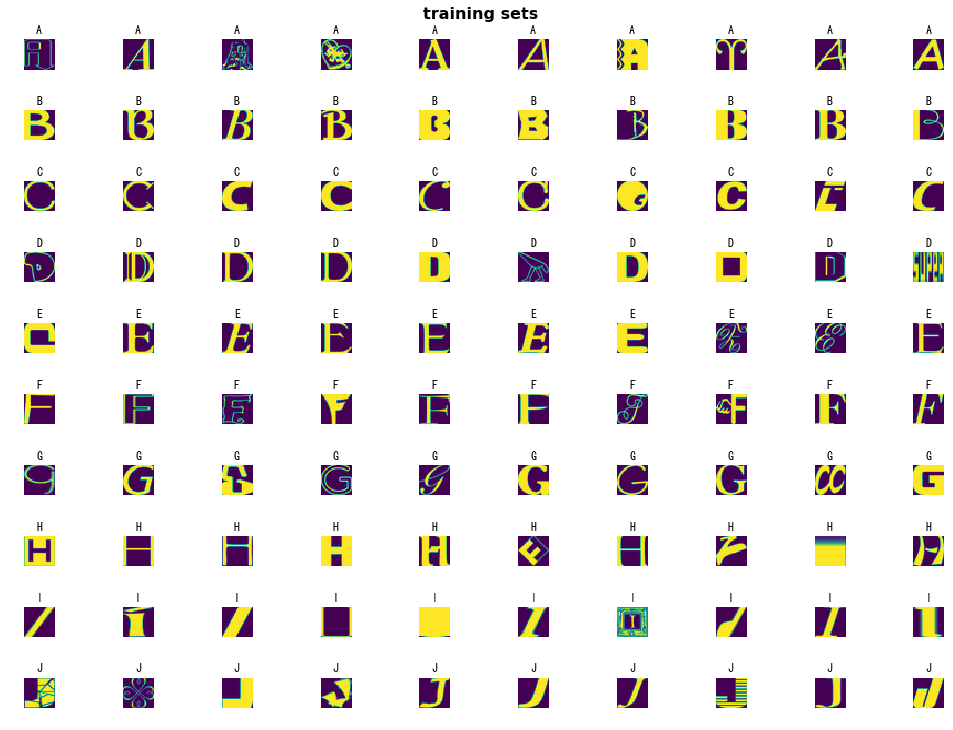

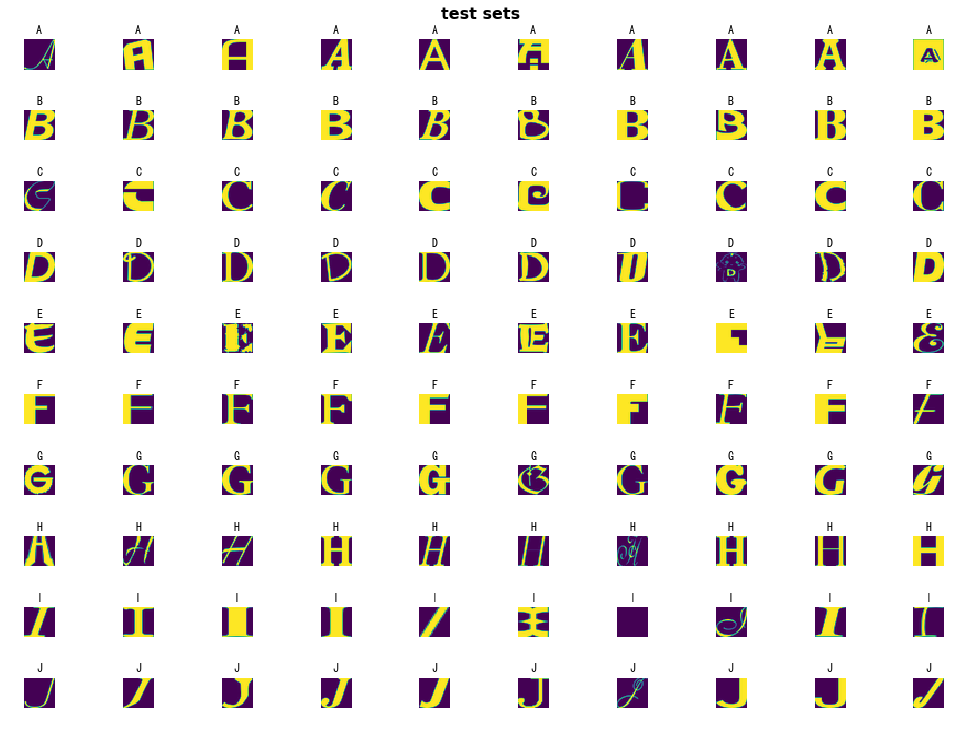

In [9]:
# 统计并查看选择好的图片
def plot_good_samples(path, sample_size, title=None):
    fig, axes = plt.subplots(10, sample_size, figsize=(14, 10))
    if title: fig.suptitle(title, y=1.01, fontsize=16, fontweight='bold')
    path = os.path.join(data_root, path)
    i = 0
    class_count = []
    for d in sorted(os.listdir(path)):
        if d.endswith('.pickle'):
            image_path = os.path.join(path, d)
            with open(image_path, 'rb') as f:
                all_images = pickle.load(f)
            class_count.append((d[0], len(all_images)))
            image_files = random.sample(list(all_images), sample_size)
            for j, im in enumerate(image_files):
                axes[i, j].imshow(im)
                axes[i, j].set_title(d[:-7])
                axes[i, j].set_axis_off()
            i += 1
    fig.tight_layout()
    return class_count

training_class_count = plot_good_samples('notMNIST_large', 10, 'training sets')
test_class_count = plot_good_samples('notMNIST_small', 10, 'test sets')

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

    我们希望数据在各个类之间是平衡的。核实一下。
---

In [10]:
training_class_count

[('A', 52909),
 ('B', 52911),
 ('C', 52912),
 ('D', 52911),
 ('E', 52912),
 ('F', 52912),
 ('G', 52912),
 ('H', 52912),
 ('I', 52912),
 ('J', 52911)]

In [11]:
test_class_count

[('A', 1872),
 ('B', 1873),
 ('C', 1873),
 ('D', 1873),
 ('E', 1873),
 ('F', 1872),
 ('G', 1872),
 ('H', 1872),
 ('I', 1872),
 ('J', 1872)]

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [12]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise

    return valid_dataset, valid_labels, train_dataset, train_labels
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, 
                                                                          train_size, 
                                                                          valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [13]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [14]:
len(train_dataset[0])

28

In [15]:
train_dataset[0].shape

(28, 28)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [16]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [17]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

在数据集中可能存在很多重复性的样本

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [18]:
train_datasets[0]

'../../nlp_data_set/notmnist/notMNIST_large/A.pickle'

In [19]:
str(imagehash.phash(Image.fromarray(train_dataset[0], mode='P')))

'cf4496d32c6862e7'

In [20]:
def overlapping(dataset_1, dataset_2):
    dataset_1_hash = np.array([str(imagehash.phash(Image.fromarray(img, mode='P'))) for img in dataset_1])
    dataset_2_hash = np.array([str(imagehash.phash(Image.fromarray(img, mode='P'))) for img in dataset_2])
    overlapping_dict = {}
    for i, img_hash in enumerate(dataset_1_hash):
        duplicates = np.where(img_hash == dataset_2_hash)[0]
        if len(duplicates) > 0:
            overlapping_dict[i] = duplicates
    return overlapping_dict

In [21]:
overlap = overlapping(train_dataset, test_dataset)

In [22]:
def plot_overlap(overlap):
    dup_list = random.sample(overlap.keys(), 4)
    target_list = [overlap[k][0] for k in dup_list]
    fig, axes = plt.subplots(4, 2, figsize=(10, 10))
    for i in range(4):
        axes[i, 0].set_title('sample from training sets')
        axes[i, 1].set_title('sample from testing sets')
        axes[i, 0].imshow(train_dataset[dup_list[i]])
        axes[i, 1].imshow(test_dataset[target_list[i]])
        axes[i, 0].set_axis_off()
        axes[i, 1].set_axis_off()

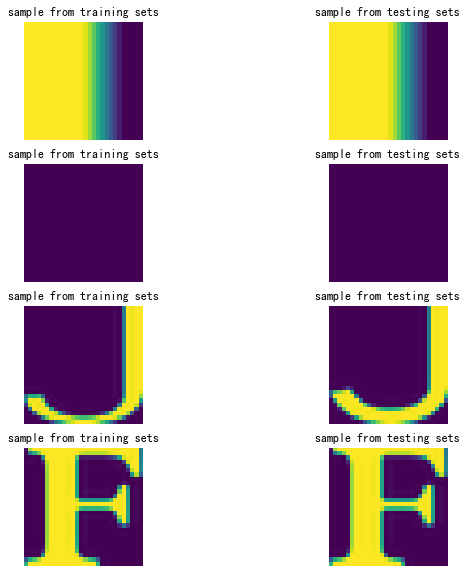

In [23]:
plot_overlap(overlap)

- 移除训练集中与测试和验证集重复的数据

In [24]:
train_dataset.shape, valid_dataset.shape, test_dataset.shape

((200000, 28, 28), (10000, 28, 28), (10000, 28, 28))

In [25]:
train_labels.shape, valid_labels.shape, test_labels.shape

((200000,), (10000,), (10000,))

In [26]:
def remove_duplicates(dataset_1, dataset_2, labels):
    dataset_1_hash = np.array(
        [str(imagehash.phash(Image.fromarray(img, mode='P'))) for img in dataset_1])
    dataset_2_hash = np.array(
        [str(imagehash.phash(Image.fromarray(img, mode='P'))) for img in dataset_2])
    overlappings_idxs = []
    for i, img_hash in enumerate(dataset_1_hash):
        duplicates = np.where(img_hash == dataset_2_hash)[0]
        if len(duplicates) > 0:
            overlappings_idxs.append(i)
    return np.delete(dataset_1, overlappings_idxs, 0), np.delete(labels, overlappings_idxs)

In [27]:
train_dataset_1, train_labels_1 = remove_duplicates(
    train_dataset, test_dataset, train_labels)
print('训练集和测试集共有{0}个相同的数据'.format(len(train_dataset) - len(train_dataset_1)))

训练集和测试集共有5302个相同的数据


In [28]:
train_dataset_2, train_labels_2 = remove_duplicates(
    train_dataset_1, valid_dataset, train_labels_1)
print('训练集和验证集共有{0}个相同的数据'.format(len(train_dataset_1) - len(train_dataset_2)))

训练集和验证集共有2359个相同的数据


In [29]:
len(train_dataset_2), len(train_labels_2)

(192339, 192339)

In [30]:
pickle_file = os.path.join(data_root, 'notMNIST_good.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset_2,
        'train_labels': train_labels_2,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [31]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 666744966


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [32]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [33]:
model_lr = LogisticRegression()
n = train_dataset_2.shape[0]

In [34]:
training_size = 50
idxs = random.sample(range(n), training_size)
x_train, y_train = train_dataset_2[idxs].reshape(training_size, -1), train_labels_2[idxs]
model_lr.fit(x_train, y_train)
model_lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

0.6322

In [35]:
training_size = 100
idxs = random.sample(range(n), training_size)
x_train, y_train = train_dataset_2[idxs].reshape(training_size, -1), train_labels_2[idxs]
model_lr.fit(x_train, y_train)
model_lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

0.6498

In [36]:
training_size = 1000
idxs = random.sample(range(n), training_size)
x_train, y_train = train_dataset_2[idxs].reshape(training_size, -1), train_labels_2[idxs]
model_lr.fit(x_train, y_train)
model_lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

0.7579

In [37]:
training_size = 5000
idxs = random.sample(range(n), training_size)
x_train, y_train = train_dataset_2[idxs].reshape(training_size, -1), train_labels_2[idxs]
model_lr.fit(x_train, y_train)
model_lr.score(valid_dataset.reshape(valid_dataset.shape[0], -1), valid_labels)

0.7735